In [375]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

Reading all the data files

In [376]:
encounters = pd.read_csv("encounters.csv")
patients = pd.read_csv("patients.csv")
conditions = pd.read_csv("conditions.csv")
allergies = pd.read_csv("allergies.csv")
observations = pd.read_csv("observations.csv")
immunizations = pd.read_csv("immunizations.csv")
medications = pd.read_csv("medications.csv")
procedures = pd.read_csv("procedures.csv")

Joining the patients and encounters dataframe

In [377]:
pat_enc = pd.merge(patients, encounters, left_on='Id', right_on='PATIENT', how='inner')

In [378]:
immunizations=immunizations[['PATIENT','ENCOUNTER','BASE_COST']].rename(columns={'BASE_COST':'IMM_COST'})
medications=medications[['PATIENT','ENCOUNTER','BASE_COST']].rename(columns={'BASE_COST':'MEDN_COST'})
procedures=procedures[['PATIENT','ENCOUNTER','BASE_COST']].rename(columns={'BASE_COST':'PROC_COST'})

In [379]:
immunizations=immunizations.groupby(['PATIENT','ENCOUNTER']).sum()
medications=medications.groupby(['PATIENT','ENCOUNTER']).sum()
procedures=procedures.groupby(['PATIENT','ENCOUNTER']).sum()
immunizations.reset_index(inplace=True)
medications.reset_index(inplace=True)
procedures.reset_index(inplace=True)

Dropping unnecessary columns from the dataframe

In [380]:
pat_enc.drop(['SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN','BIRTHPLACE', 'ADDRESS','COUNTY', 'ZIP', 'LAT', 'LON','PATIENT'], axis=1, inplace=True)

In [381]:
pat_enc = pat_enc[pat_enc['DEATHDATE'].isnull()]

Joining immunizations, medications, procedures to get the total expense incurred on these 

In [382]:
pat_enc = pd.merge(pat_enc,immunizations, left_on='Id_y',right_on='ENCOUNTER', how='left')
pat_enc = pd.merge(pat_enc,medications, left_on='Id_y',right_on='ENCOUNTER', how='left')
pat_enc = pd.merge(pat_enc,procedures, left_on='Id_y',right_on='ENCOUNTER', how='left')

Function to calculate Age

In [383]:
from datetime import datetime, date

def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

In [384]:
pat_enc['Age'] = pat_enc['BIRTHDATE'].apply(age)
pat_enc.drop(['BIRTHDATE','DEATHDATE'], axis=1, inplace=True)

In [385]:
pat_enc = pat_enc[['Id_x','Id_y', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'CITY',
         'START', 'STOP', 'ENCOUNTERCLASS', 'CODE',
       'BASE_ENCOUNTER_COST', 'IMM_COST', 'MEDN_COST', 'PROC_COST',
       'Age']]

Encoding the categorical data

In [386]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pat_enc['MARITAL'] = pat_enc['MARITAL'].fillna('NA')

pat_enc['CODE'] = pat_enc['CODE'].map(str)

In [387]:
feat_dummies= pd.get_dummies(pat_enc[['MARITAL','RACE','ETHNICITY','GENDER']], prefix_sep='_', drop_first=False)

In [388]:
pat_enc.drop(['MARITAL','RACE','ETHNICITY','GENDER'], axis=1, inplace=True)

In [389]:
pat_enc= pd.concat([feat_dummies,pat_enc], axis=1)

In [390]:
pat_enc = pat_enc.fillna(0)

In [391]:
pat_enc['VALUE'] = 1
pivot_df = pat_enc.pivot(index=['Id_x','Id_y'], columns=['CODE','ENCOUNTERCLASS'] , values='VALUE')

In [392]:
pivot_df.reset_index(inplace=True)
pivot_df=pivot_df.fillna(0)

In [393]:
pivot_df = pivot_df.groupby('Id_x').sum()

C:\Users\soodi\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [394]:
pivot_df.reset_index(inplace=True)
pat_enc.reset_index(inplace=True)

In [395]:
pat_enc.drop(['index','Id_y','CITY','START','STOP'],axis=1, inplace=True)

Aggregating the values as Patient Id level

In [396]:
pat_enc = pat_enc.groupby('Id_x').agg({'Age':max,'MARITAL_M':max,'MARITAL_NA':max,'MARITAL_S':max,'RACE_asian':max,'RACE_black':max,'RACE_native':max,'RACE_other':max,'RACE_white':max,'ETHNICITY_hispanic':max,'ETHNICITY_nonhispanic':max,'GENDER_F':max,'GENDER_M':max,'BASE_ENCOUNTER_COST':sum, 'IMM_COST':sum, 'MEDN_COST':sum, 'PROC_COST':sum})

In [397]:
pat_enc.reset_index(inplace=True)

In [398]:
cond_df =  pd.concat([conditions[['PATIENT','CODE']],allergies[['PATIENT','CODE']]],axis=0)
cond_df['Value'] = 1

In [399]:
cond_df = cond_df.groupby(['PATIENT','CODE']).count()

In [400]:
cond_df.reset_index(inplace=True)


Encoding the values of Condition(Illness or allergies) code

In [401]:
cond_df = cond_df.pivot(index=['PATIENT'], columns='CODE', values='Value').fillna(0)

In [402]:
cond_df.head(5)

CODE,1734006,5602001,6072007,7200002,10509002,11218009,15724005,15777000,16114001,19169002,22298006,24079001,26929004,30832001,33737001,35999006,36923009,36971009,38822007,39848009,40055000,40275004,43878008,44054006,44465007,45816000,47200007,47505003,47693006,48333001,49436004,53741008,55680006,55822004,58150001,59621000,62106007,62564004,64859006,65275009,65363002,65710008,65966004,68496003,69896004,70704007,72892002,74400008,75498004,79586000,...,363406005,367498001,370143000,370247008,398254007,399211009,403190006,403191005,403192003,406602003,408512008,410429000,417532002,418689008,419263009,419474003,420174000,422034002,424132000,424213003,425525006,427089005,428251008,429007001,429280009,431855005,431856006,433144002,443165006,444448004,444470001,444814009,446096008,448417001,448813005,449868002,698754002,703151001,707577004,713197008,714035009,1501000119109,1551000119108,60951000119105,67811000119102,90781000119102,97331000119101,124171000119105,157141000119108,368581000119106
PATIENT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00059e58-4f1f-49de-b008-3ec6c2aac7e7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007fa20-c7b2-4764-b4f1-c3e96b241082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000f6134-cefd-41f8-8bc7-144221c7e07e,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ffb8b-d295-44a7-9d88-45d39ea9d2ba,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [403]:
final_df = pd.merge(pat_enc, cond_df, left_on='Id_x',right_on='PATIENT', how='inner')

In [404]:
final_df.head(5)

,Id_x,Age,MARITAL_M,MARITAL_NA,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,GENDER_F,GENDER_M,BASE_ENCOUNTER_COST,IMM_COST,MEDN_COST,PROC_COST,1734006,5602001,6072007,7200002,10509002,11218009,15724005,15777000,16114001,19169002,22298006,24079001,26929004,30832001,33737001,35999006,36923009,36971009,38822007,39848009,40055000,40275004,43878008,44054006,44465007,45816000,47200007,47505003,47693006,48333001,49436004,53741008,...,363406005,367498001,370143000,370247008,398254007,399211009,403190006,403191005,403192003,406602003,408512008,410429000,417532002,418689008,419263009,419474003,420174000,422034002,424132000,424213003,425525006,427089005,428251008,429007001,429280009,431855005,431856006,433144002,443165006,444448004,444470001,444814009,446096008,448417001,448813005,449868002,698754002,703151001,707577004,713197008,714035009,1501000119109,1551000119108,60951000119105,67811000119102,90781000119102,97331000119101,124171000119105,157141000119108,368581000119106
0,0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,80,0,0,1,0,0,0,0,1,0,1,0,1,18469.88,8993.28,8653.57,58518.53,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00059e58-4f1f-49de-b008-3ec6c2aac7e7,49,1,0,0,0,0,0,0,1,0,1,1,0,15628.36,5901.84,1334.57,861779.22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0007fa20-c7b2-4764-b4f1-c3e96b241082,23,0,1,0,0,0,0,0,1,0,1,1,0,7749.60,7026.00,1974.76,54838.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000f6134-cefd-41f8-8bc7-144221c7e07e,82,1,0,0,0,0,0,0,1,0,1,0,1,18857.36,8852.76,13902.68,204560.05,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000ffb8b-d295-44a7-9d88-45d39ea9d2ba,61,1,0,0,0,0,0,0,1,0,1,0,1,24152.92,9133.80,69484.33,100747.40,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [405]:
for c in final_df.columns:
    print(c)

Id_x
Age
MARITAL_M
MARITAL_NA
MARITAL_S
RACE_asian
RACE_black
RACE_native
RACE_other
RACE_white
ETHNICITY_hispanic
ETHNICITY_nonhispanic
GENDER_F
GENDER_M
BASE_ENCOUNTER_COST
IMM_COST
MEDN_COST
PROC_COST
1734006
5602001
6072007
7200002
10509002
11218009
15724005
15777000
16114001
19169002
22298006
24079001
26929004
30832001
33737001
35999006
36923009
36971009
38822007
39848009
40055000
40275004
43878008
44054006
44465007
45816000
47200007
47505003
47693006
48333001
49436004
53741008
55680006
55822004
58150001
59621000
62106007
62564004
64859006
65275009
65363002
65710008
65966004
68496003
69896004
70704007
72892002
74400008
75498004
79586000
80394007
82423001
83664006
84757009
86849004
87433001
88805009
90560007
91930004
91934008
91935009
92691004
93761005
94260004
95417003
109838007
110030002
126906006
127013003
127295002
128613002
156073000
161621004
161622006
162573006
162864005
185086009
190905008
192127007
195662009
195967001
196416002
197927001
198992004
200936003
201834006
20652

In [406]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
ip_df = final_df[['Age','BASE_ENCOUNTER_COST','IMM_COST','MEDN_COST','PROC_COST']]
mms_df = mms.fit_transform(ip_df)
final_df[['Age','BASE_ENCOUNTER_COST','IMM_COST','MEDN_COST','PROC_COST']] = pd.DataFrame(mms_df, columns =['AGE','BASE_ENCOUNTER_COST','IMM_COST','MEDN_COST','PROC_COST'])

In [407]:
patients_final = pd.merge(patients,final_df, left_on='Id', right_on='Id_x', how='inner')

In [408]:
final_df.drop(['Id_x'],axis=1, inplace=True)

In [409]:
final_df.head(5)

,Age,MARITAL_M,MARITAL_NA,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,GENDER_F,GENDER_M,BASE_ENCOUNTER_COST,IMM_COST,MEDN_COST,PROC_COST,1734006,5602001,6072007,7200002,10509002,11218009,15724005,15777000,16114001,19169002,22298006,24079001,26929004,30832001,33737001,35999006,36923009,36971009,38822007,39848009,40055000,40275004,43878008,44054006,44465007,45816000,47200007,47505003,47693006,48333001,49436004,53741008,55680006,...,363406005,367498001,370143000,370247008,398254007,399211009,403190006,403191005,403192003,406602003,408512008,410429000,417532002,418689008,419263009,419474003,420174000,422034002,424132000,424213003,425525006,427089005,428251008,429007001,429280009,431855005,431856006,433144002,443165006,444448004,444470001,444814009,446096008,448417001,448813005,449868002,698754002,703151001,707577004,713197008,714035009,1501000119109,1551000119108,60951000119105,67811000119102,90781000119102,97331000119101,124171000119105,157141000119108,368581000119106
0,0.711712,0,0,1,0,0,0,0,1,0,1,0,1,0.024602,0.750000,0.006306,0.003015,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.432432,1,0,0,0,0,0,0,1,0,1,1,0,0.020708,0.460526,0.000973,0.044405,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.198198,0,1,0,0,0,0,0,1,0,1,1,0,0.009912,0.565789,0.001439,0.002826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.729730,1,0,0,0,0,0,0,1,0,1,0,1,0.025133,0.736842,0.010131,0.010540,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.540541,1,0,0,0,0,0,0,1,0,1,0,1,0.032389,0.763158,0.050636,0.005191,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering using PCA

Sine we are dealing with 172 attributes, our analysis will be impac ted by curse of dimensionality. So let us perform Principal Component Analysis to identify those principal components that explain most of the variance in the dataset.

In [410]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(final_df)
variance_ratio = pca.explained_variance_ratio_
variance_ratio

array([0.42656985, 0.19604324, 0.07211802, 0.05227416, 0.02760884,
       0.01942746, 0.01293434, 0.0111681 , 0.0094342 , 0.00815018,
       0.00723204, 0.00665068, 0.00618982, 0.0058213 , 0.00532949,
       0.00503755, 0.00495118, 0.00484789, 0.00469632, 0.00450316])

Text(0.5, 0, 'Variance')

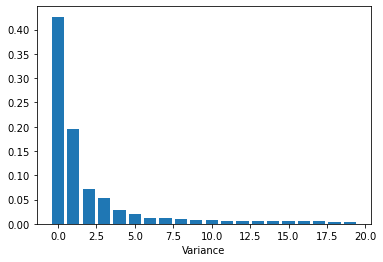

In [411]:
import matplotlib.pyplot as plt
features = range(pca.n_components)
plt.bar(features, variance_ratio)
plt.xlabel('PCA feature')
plt.xlabel('Variance')

In [412]:
variance_ratio_cumsum = np.cumsum(variance_ratio)

In [413]:
print(variance_ratio_cumsum)

[0.42656985 0.6226131  0.69473112 0.74700528 0.77461412 0.79404158
 0.80697592 0.81814402 0.82757822 0.83572839 0.84296043 0.8496111
 0.85580093 0.86162222 0.86695171 0.87198926 0.87694044 0.88178834
 0.88648466 0.89098782]


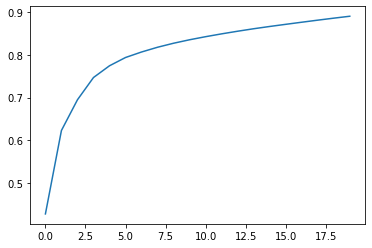

In [414]:
plt.plot(variance_ratio_cumsum)

We can see that 20 pca components explain 90% of the variance

In [415]:
Transformed_vector =  pca.transform(final_df)
print(Transformed_vector)

[[ 3.49723828  5.86257336  1.60763664 ...  0.0141883  -0.06235606
  -0.54820667]
 [ 0.50656263 -3.3608812  -0.27453135 ... -0.1008228  -0.38868942
  -0.68013697]
 [-3.11080387  0.36589161 -2.42285523 ... -0.17718228  0.05515583
   0.01361688]
 ...
 [-1.68965383  1.40926604  2.16238098 ... -0.0757212  -0.31254523
  -0.2585012 ]
 [-4.64234317 -0.69151732 -1.49700691 ... -0.15968198  0.04422631
   0.08640989]
 [ 3.30278183 -2.59266519  1.52383612 ... -0.02064502 -0.38292408
  -0.57586492]]


### Visualizing Principal Components using scatter plot

Text(0.5, 0, 'PCA 1')

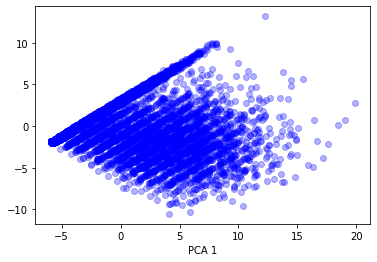

In [416]:
PCA_df =  pd.DataFrame(Transformed_vector)
plt.scatter(PCA_df[0],PCA_df[1], alpha=.3, color='blue')
plt.xlabel('PCA 0')
plt.xlabel('PCA 1')

Text(0.5, 0, 'PCA 4')

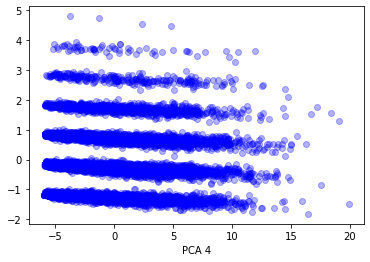

In [417]:
plt.scatter(PCA_df[0],PCA_df[4], alpha=.3, color='blue')
plt.xlabel('PCA 0')
plt.xlabel('PCA 4')

We can leverage the power of PCA to discover clusters in the dastaset

In [418]:
from sklearn.cluster import KMeans
num_clusters = range(2,40)
error = []
for n in num_clusters:
    clusters = KMeans(n)
    clusters.fit(Transformed_vector)
    error.append(clusters.inertia_/100)
df = pd.DataFrame({"Cluster_numbers":num_clusters,"Error_Term":error})


In [419]:
df

,Cluster_numbers,Error_Term
0,2,2433.479172
1,3,1841.359603
2,4,1666.901938
3,5,1524.024716
4,6,1455.814923
5,7,1394.600843
6,8,1340.763496
7,9,1290.948254
8,10,1255.379063
9,11,1223.922167


In [420]:
clusters.inertia_

89525.36095201326

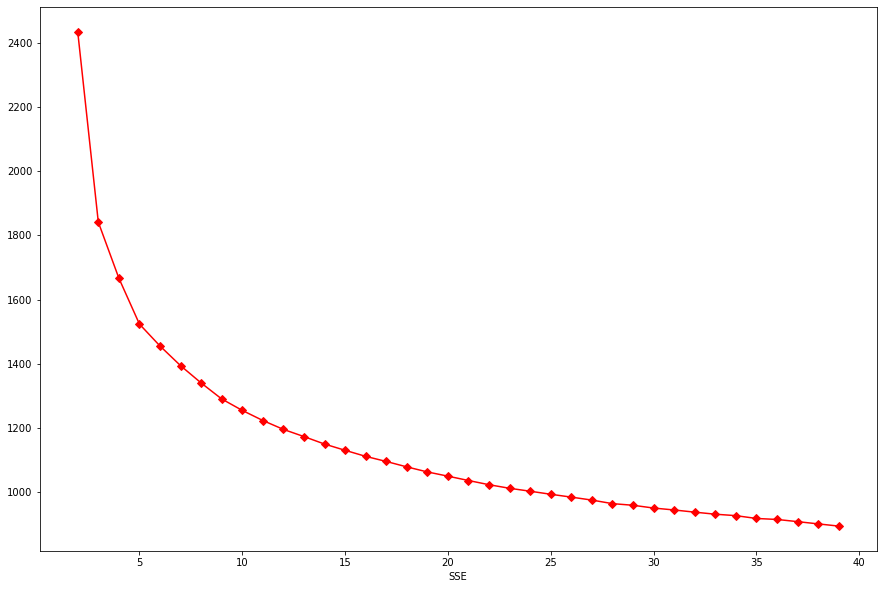

In [421]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(df.Cluster_numbers,df.Error_Term, marker="D", color='red')
plt.xlabel('Num of clusters')
plt.xlabel('SSE')
plt.show()

As visible in the above graph, the curve is less steep n = 10. we will take n=10 to build our model

In [422]:
clus =  KMeans(10)
clus.fit(Transformed_vector)
clus.labels_

array([8, 7, 1, ..., 4, 3, 7])

In [423]:
dff = pd.DataFrame({'labels':clus.labels_})

In [424]:
dff = pd.concat([dff,patients_final], axis=1)

In [425]:
dff = dff[['labels','FIRST','LAST','BIRTHPLACE','ADDRESS','COUNTY','ZIP','BIRTHDATE','DEATHDATE','SSN','DRIVERS','PASSPORT','PREFIX','HEALTHCARE_EXPENSES','HEALTHCARE_COVERAGE']]

In [426]:
dff.sort_values('labels')

,labels,FIRST,LAST,BIRTHPLACE,ADDRESS,COUNTY,ZIP,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
6054,0,Dillon740,Brakus656,Daegu Daegu KR,435 Raynor Boulevard,Essex County,NaN,1964-09-07,NaN,999-96-3428,S99954148,X10368569X,Mr.,1488362.48,5442.08
4737,0,Daryl568,Padberg411,Bedford Massachusetts US,209 Towne Spur,Suffolk County,2163.0,1956-02-06,NaN,999-67-5629,S99973636,X4511076X,Mr.,1323317.02,7559.96
6392,0,Linnea167,Marvin195,Boston Massachusetts US,740 Rath Gateway Apt 92,Middlesex County,2155.0,2010-03-19,NaN,999-38-7150,NaN,NaN,NaN,244499.82,2774.84
6960,0,Fiona703,Brown30,Revere Massachusetts US,766 Hartmann Well Suite 23,Suffolk County,NaN,2013-03-24,NaN,999-20-3977,NaN,NaN,NaN,172435.74,2194.88
1929,0,Stewart672,Stanton715,Boston Massachusetts US,456 Eichmann Plaza Unit 22,Worcester County,NaN,2013-05-10,NaN,999-40-6767,NaN,NaN,NaN,168065.00,2001.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,9,Olivia294,Parisian75,Fall River Massachusetts US,820 Ward Junction Suite 71,Suffolk County,2130.0,1973-08-08,NaN,999-88-6407,S99943432,X11175464X,Mrs.,1130458.88,6738.23
4927,9,Machelle279,Labadie908,Holliston Massachusetts US,516 Spencer Haven Apt 79,Suffolk County,2210.0,1992-11-09,NaN,999-67-7851,S99951975,X63864276X,Ms.,637136.00,4457.92
4925,9,Brant303,Steuber698,Hong Kong Hong Kong Special Administrative Re...,501 Schmeler Mews Unit 35,Worcester County,NaN,1983-12-29,NaN,999-70-7254,S99937374,X74632192X,Mr.,971988.03,2722.28
4894,9,Tracee120,Wisoky380,Waltham Massachusetts US,250 Moen Forge,Essex County,NaN,1985-12-29,NaN,999-93-8135,S99969240,X42626420X,Ms.,737580.92,10498.97
